In [2]:
!pip install lxml
import os
import time
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import regex as re
import requests
import plotly.express as px
import plotly.graph_objects as go
import json
import datetime
from scipy import stats
import tqdm
import time
from bs4 import BeautifulSoup
from lxml import etree

## Extracting zipcodes in Yolo county

In [3]:


# Your provided URL and headers
county_url = 'https://www.zillow.com/browse/homes/ca/yolo-county/'
req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'accept-encoding': 'gzip, deflate, br, zstd',
    'accept-language': 'en-US,en;q=0.9,fa;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36'
}

r = requests.get(county_url, headers=req_headers)
time.sleep(1.0)  # It's good that you're being respectful with the timing

# Parse the HTML with lxml
html_tree = etree.HTML(r.content)

# Corrected XPath query to target the <a> tags directly within the <li> elements
xpath_query = '//*[@id="wrapper"]/div[2]/main/div[2]/div[1]/section/ul/li/a'

# Use the XPath query to find the elements
elements = html_tree.xpath(xpath_query)

# Extract the zip codes from the text content of each <a> tag found
zip_codes = [element.text for element in elements]

print(zip_codes)


['95616', '95691', '95695', '95776', '95618', '95620', '95605', '95694', '95457', '95627', '94243', '95612', '95645', '95607', '95937', '95698', '95637', '95606', '95679', '95697', '95653', '95617', '95798', '95799', '95899']


## Exctracting neighbourhoods in each zipcode

In [11]:
# Dictionary to hold zip codes and their neighborhoods
zip_codes_and_neighborhoods = {}
# Dictionary to hold response from the indiividual zipcodes and their neighborhoods
response_zip_to_neighbourhood_dict = {}
zip_codes_response_200 = []
zip_codes_response_403 = list(zip_codes)

In [12]:

response_zip_to_neighbourhood_dict.keys()


dict_keys([])

In [15]:
import random

req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'accept-encoding': 'gzip, deflate, br, zstd',
    'accept-language': 'en-US,en;q=0.9,fa;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36'
}

for key in response_zip_to_neighbourhood_dict.keys():
    if key in zip_codes_response_403:
        zip_codes_response_403.remove(key)
        zip_codes_response_200.append(key)


# Split the list of zip codes into 4-element batches
batch_size = 4
zip_code_batches = [zip_codes_response_403[i:i + batch_size] for i in range(0, len(zip_codes_response_403), batch_size)]
stop_flag = False

for batch in zip_code_batches:
    for zip_code in batch:

        zip_code_url = county_url + zip_code + '/'

        # Make a request to the zip code specific page
        response = requests.get(zip_code_url, headers=req_headers)


        if(response.status_code == 403):
            stop_flag = True
            break

        response_zip_to_neighbourhood_dict[zip_code] = response

        time.sleep(random.uniform(1.0, 2.0))  # Random delay between requests within the same batch

        # Parse the HTML of the zip code page
        html_tree = etree.HTML(response.content)

        # XPath to find neighborhoods
        neighborhoods_xpath = '//*[@id="wrapper"]/div[2]/main/div[3]/div[2]/div/div/ul/li/a'
        if zip_code in ['94243', '95798', '95799', '95899']:
            neighborhoods_xpathhoo = '//*[@id="wrapper"]/div[2]/main/div[3]/div/div/div/ul/li/a'

        # Extract neighborhood elements
        neighborhood_elements = html_tree.xpath(neighborhoods_xpath)

        # Extract the neighborhood names
        neighborhoods = [elem.text.strip() for elem in neighborhood_elements]

        # Add to dictionary
        zip_codes_and_neighborhoods[zip_code] = neighborhoods


    time.sleep(random.uniform(6.0, 14.0))  # Random delay between requests within the same batch

#print(zip_codes_and_neighborhoods)


In [17]:
print(f"Extracted : {len(zip_codes_response_200)}/{len(zip_codes)} , Remaining : {len(zip_codes_response_403)}/{len(zip_codes)}")


Extracted : 25/25 , Remaining : 0/25


These zipcodes have different xpath, we found them by investigating the number of the values in each key:value pairs of the `zip_codes_and_neighborhoods` dictionary, we found the non default xpath and in the following will use the `response_zip_to_neighbourhood_dict` that saved the corresponding response of each zip code from the zillow server. It's very important to keep the responses to keep the integrity of the data during the data cleaning stage.

In [18]:
import json
with open("Zip_Neighbourhoods_Yolo_County.json", "w") as outfile:
    json.dump(zip_codes_and_neighborhoods, outfile)

We successfully extracted all the Zipcode's neighbourhooods in Yolo county from the Zillow, To run this you need to set the request header according to your own environemnt, please note you may see different status codes for each batch. upon a failure on a batch zipcode, the batch's remaining zipcode will be skipped to sudo randomize the traffic inorder to prevent our IP address getting blocked by Zillow. In this regard you need to run the last two cells as much as needed till the last cell confirms that all the neighbourhoods in the yolo county are successfully extracted (25/25)

## Overlap of neighbourhoods
we found that there is an extensive overlap among the neighbourhoods in the extracted data, hence we concloduded that the neighbourhood iteself doesn't contribute to the main goal of the project. In this regards, we decided to change the granularity of the project from the neighbourhood granularity to zipcode.

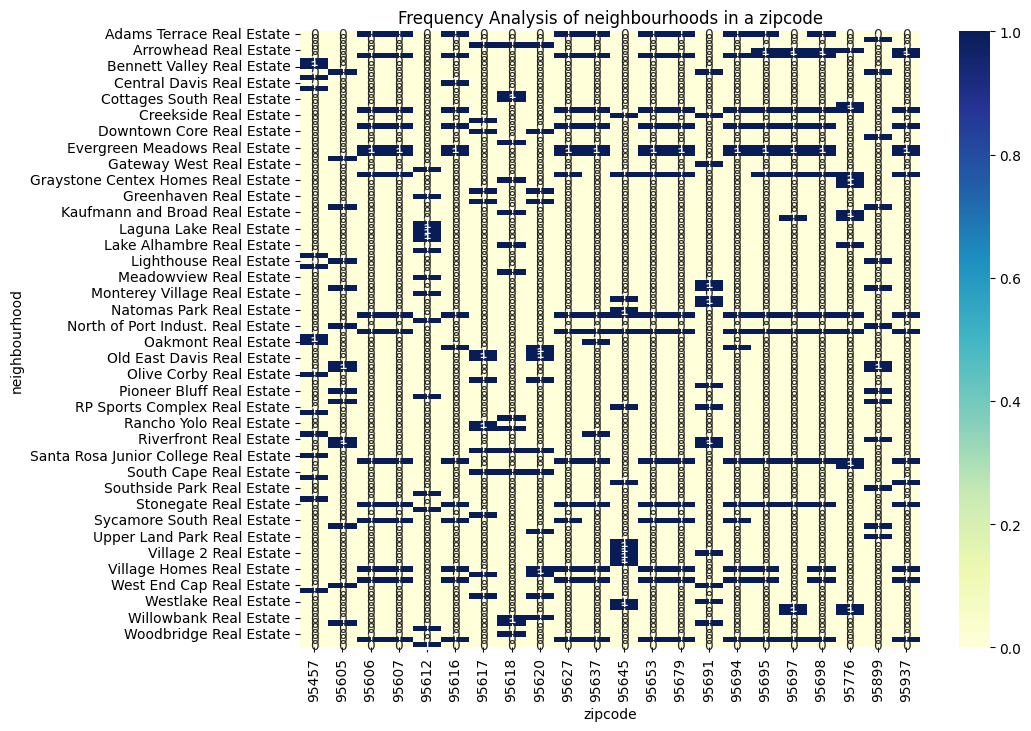

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert dictionary to a list of tuples (key, value)
data = [(key, value) for key, values in zip_codes_and_neighborhoods.items() for value in values]

# Create a DataFrame from the list
df = pd.DataFrame(data, columns=['zipcode', 'neighbourhood'])

# Perform a frequency analysis
frequency_df = df.groupby('neighbourhood').size().reset_index(name='Frequency')

# Pivot the DataFrame for heatmap
pivot_df = df.pivot_table(index='neighbourhood', columns='zipcode', aggfunc=len, fill_value=0)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu")
plt.title('Frequency Analysis of neighbourhoods in a zipcode')
plt.show()


Once Again let's review the available zipcodes:

In [ ]:
print(list(zip_codes))

['95616', '95691', '95695', '95776', '95618', '95620', '95605', '95694', '95457', '95627', '94243', '95612', '95645', '95607', '95937', '95698', '95637', '95606', '95679', '95697', '95653', '95617', '95798', '95799', '95899']
